In [63]:
import json
import logging
import sys
import os

import numpy as np
import pandas as pd
import torch

sys.path.append("../..")
sys.path.append("..")
from optimneuralts import DENeuralTSDiag, LenientDENeuralTSDiag
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
def load_dataset(dataset_path):
    dataset = pd.read_csv("../datasets/combinations/" + dataset_path + ".csv")

    with open("../datasets/patterns/" + dataset_path + ".json", "r") as f:
        patterns = json.load(f)

    features = dataset.iloc[:, :-3]
    risks = dataset.iloc[:, -3]

    n_obs, n_dim = features.shape

    return features, risks, patterns, n_obs, n_dim

In [65]:
dataset = "100_rx_100000_combis_10_patterns_42"
combis, risks, patterns, n_obs, n_dim = load_dataset(dataset)

pat_vecs = torch.tensor(
    [patterns[f"pattern_{i}"]["pattern"] for i in range(len(patterns))]
)
combis, risks = (
    torch.tensor(combis.values).float(),
    torch.tensor(risks.values).unsqueeze(1).float(),
)

sol_idx = torch.where(risks > 2)[0]
sol_combis = combis[sol_idx]


In [66]:
# exp = dataset
exp = "100_rx_100000_combis_10_patterns_42_0.1expl_100width"
mus = []
cbs = []
for i in range(25):
    model = torch.load(f"../saves/{exp}/agents/{i}.pth")
    found_pat, m, c = model.find_solution_in_vecs(pat_vecs, 2)
    mus.append(m)
    cbs.append(c)


<BarContainer object of 10 artists>

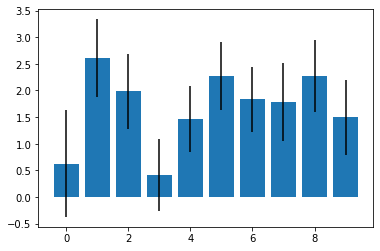

In [67]:
import matplotlib.pyplot as plt
mus = np.mean(mus, axis=0)
cbs = np.mean(cbs, axis=0)

plt.bar(list(range(10)), mus, yerr=cbs)

In [68]:

for i in range(25):
    model = torch.load(f'../saves/{exp}/agents/{i}.pth')
    with torch.no_grad():
        activs = model.net(sol_combis)

    print(activs[:10])
    print(risks[sol_idx])
    print("====")

tensor([[1.0969],
        [1.8172],
        [1.2862],
        [1.4033],
        [1.3088],
        [1.8830],
        [1.3765],
        [1.0442],
        [1.4847],
        [2.2234]])
tensor([[2.0100],
        [2.0300],
        [2.0300],
        ...,
        [2.0300],
        [2.0500],
        [2.0100]])
====
tensor([[0.8834],
        [1.7405],
        [1.1334],
        [1.5931],
        [1.0661],
        [1.4338],
        [1.0019],
        [1.5516],
        [1.5052],
        [1.3986]])
tensor([[2.0100],
        [2.0300],
        [2.0300],
        ...,
        [2.0300],
        [2.0500],
        [2.0100]])
====
tensor([[0.9246],
        [1.2643],
        [1.0611],
        [1.5574],
        [0.9522],
        [0.9491],
        [1.1812],
        [1.0248],
        [1.0927],
        [1.7057]])
tensor([[2.0100],
        [2.0300],
        [2.0300],
        ...,
        [2.0300],
        [2.0500],
        [2.0100]])
====
tensor([[1.0830],
        [1.0960],
        [0.7214],
        [1.1108],
    

<BarContainer object of 25 artists>

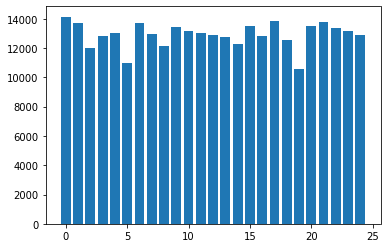

In [69]:

ns = []

for i in range(25):
    model = torch.load(f'../saves/{exp}/agents/{i}.pth')
    n_played, counts = torch.unique(model.vec_history, return_counts=True, dim=0)
    ns.append(len(n_played))
plt.bar(x=list(range(25)), height=ns)